<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [29]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [30]:
!nvidia-smi

Thu Sep 17 00:37:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |    787MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [32]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [33]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [34]:
X.head()

,ID,WF,U_100m,V_100m,U_10m,V_10m,T,CLCT,Set,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,...,CLCT_Distance_Max,CLCT_Distance_Min,U_100m_Distance_Max,U_100m_Distance_Min,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,12479,WF3,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,Train,6.936299,0.583268,1.687717,0.895782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.690,86.504507,5.7895,3.8202,1.054669,1.317597
2018-05-01 02:00:00,12480,WF3,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,Train,7.170127,0.578533,1.723264,1.036951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.770,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 03:00:00,12481,WF3,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,Train,6.000870,0.151837,1.707938,0.981212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 04:00:00,12482,WF3,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,Train,5.470862,0.312855,1.454695,0.786528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 05:00:00,12483,WF3,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,Train,4.896512,0.143904,1.280704,0.660129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-159,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483


## Scaling Data

For a better performance of the Network, here the data is scaled between [-1,1] using MinMaxScaler. For the Direction Data, presented in degrees, Sin and Cos are calculated, which naturally have values in this same scale.

In [35]:
def preprocessing_X(X):

  scaler = MinMaxScaler(feature_range=(-1,1))

  X_saved_columns = X[['ID','WF','Set','Month_Number']]
  X_saved_columns = X_saved_columns.reset_index().drop('Time',axis=1)
  X = X.drop(['ID','WF','Set','Month_Number'],axis=1)

  # Fill NaN's
  X = X.fillna(method="ffill", axis=1) # ZOH
  X = X.fillna(0)

  # Scaling Data
  directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
  directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
  directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
  directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
  directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))
  directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  directions = directions.reset_index().drop('Time',axis=1)

  X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  X_columns = X.columns

  X = scaler.fit_transform(X)
  X = pd.DataFrame(X,columns=X_columns)
  X = pd.concat([X,directions],axis=1)
  X = pd.concat([X,X_saved_columns],axis=1)

  return X

In [36]:
def preprocessing_y(y):

  scaler = MinMaxScaler(feature_range=(-1,1))

  y = y.fillna(method="ffill", axis=1) # ZOH
  y = y.fillna(0)
  y = y.drop('ID',axis=1)
  y = scaler.fit_transform(y)
  y = pd.DataFrame(y)

  return y,scaler

In [37]:
y.shape

(6239, 2)

## Subsets Creation

Here, the Data is converted to a group of subsets where each subset has n_steps of past data.

In [38]:
n_steps = 30

In [39]:
# split a multivariate sequence into samples
def split_sequences(X, y = None, n_steps = 1):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x = X[i:end_ix, :]
		sample_X.append(seq_x)
		if y is not None:
			seq_y = y[end_ix-1,-1]
			sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [40]:
def shift_save(df,n_steps):
  empty = pd.DataFrame(np.zeros((n_steps-1,df.shape[1])),columns=df.columns)
  df = pd.concat([empty,df])
  return df

In [41]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [42]:
n_features = sample_X.shape[2] - 2

## Model

Here, a function to create the Model usin Keras is defined.

In [60]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=128,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.2)(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=87,return_sequences=True,stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.2)(hidden_2)

  hidden_3 = tf.keras.layers.LSTM(units=57,stateful=True)(hidden_2)
  hidden_3 = tf.keras.layers.Dropout(0.2)(hidden_3)

  # Output
  #outputs = tf.keras.layers.PReLU()(hidden_2)
  #outputs = tf.keras.layers.Dropout(rate=0.2)(hidden_2)
  outputs = tf.keras.layers.Dense(units=1)(hidden_3)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [44]:
input_shape = (n_steps,n_features)

In [45]:
model = LSTM_Model(input_shape)

In [46]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(1, 30, 94)]             0         
_________________________________________________________________
lstm_21 (LSTM)               (1, 30, 128)              114176    
_________________________________________________________________
dropout_21 (Dropout)         (1, 30, 128)              0         
_________________________________________________________________
lstm_22 (LSTM)               (1, 30, 87)               75168     
_________________________________________________________________
dropout_22 (Dropout)         (1, 30, 87)               0         
_________________________________________________________________
lstm_23 (LSTM)               (1, 57)                   33060     
_________________________________________________________________
dropout_23 (Dropout)         (1, 57)                 

## Validation

In [47]:
random.seed(317)
tf.random.set_seed(317)

patience = 3
epochs = 10
k_fold_splits = 5
total_it = 50
monitor = "root_mean_squared_error"
batch_size = 1

In [48]:
# Define Time Split Cross Validation
tscv = TimeSeriesSplit(n_splits=k_fold_splits)

# Separating Data from Hold Out Set

X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

train_scores = np.empty(0)
val_scores = np.empty(0)
test_scores = np.empty(0)
for train_index, test_index in tscv.split(X_cv):

    #train_index = train_index[-n_rows:]
    #test_index = test_index[-n_rows:]

    # Get the Data of the Split
    X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Separating Training Set of Split on Train and Validation Subsets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    # Preprocessing Data
    X_train = preprocessing_X(X_train)
    X_val = preprocessing_X(X_val)
    X_test = preprocessing_X(X_test)

    X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_test = X_test.drop(['ID','WF','Set','Month_Number'],axis=1)

    y_train,_ = preprocessing_y(y_train)
    y_val,_ = preprocessing_y(y_val)
    y_test,_ = preprocessing_y(y_test)

    # Reshape Data
    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, y_test = split_sequences(X_test.values,y_test.values,n_steps)

    # Create Model
    model = LSTM_Model(input_shape,batch_size=batch_size)

    # Callbacks
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]

    # Train the Model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Train and Validation Score
    train_score = np.array(history.history['root_mean_squared_error']).mean()
    val_score = np.array(history.history['val_root_mean_squared_error']).mean()

    # Test Score
    preds = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    preds = tf.cast(preds, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(y_test,preds)
    test_score = m.result().numpy()

    train_scores = np.append(train_scores,train_score)
    val_scores = np.append(val_scores,val_score)
    test_scores = np.append(test_scores,test_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
754/754 [==============================] - 7s 9ms/step - loss: 0.1410 - root_mean_squared_error: 0.3755 - val_loss: 0.2070 - val_root_mean_squared_error: 0.4550
Epoch 2/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1412 - root_mean_squared_error: 0.3757 - val_loss: 0.2148 - val_root_mean_squared_error: 0.4635
Epoch 3/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1462 - root_mean_squared_error: 0.3823 - val_loss: 0.1871 - val_root_mean_squared_error: 0.4325
Epoch 4/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1348 - root_mean_squared_error: 0.3672 - val_loss: 0.1772 - val_root_mean_squared_error: 0.4209
Epoch 5/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1062 - root_mean_squared_error: 0.3260 - val_loss: 0.1166 - val_root_mean_squared_error: 0.3414
Epoch 6/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1102 - root_mean_squared_error: 0.3320 - val_loss: 0.1473 - val_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
1533/1533 [==============================] - 13s 8ms/step - loss: 0.1142 - root_mean_squared_error: 0.3380 - val_loss: 0.1843 - val_root_mean_squared_error: 0.4293
Epoch 2/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.1024 - root_mean_squared_error: 0.3201 - val_loss: 0.2341 - val_root_mean_squared_error: 0.4839
Epoch 3/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.1076 - root_mean_squared_error: 0.3281 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4186
Epoch 4/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.1041 - root_mean_squared_error: 0.3226 - val_loss: 0.1681 - val_root_mean_squared_error: 0.4100
Epoch 5/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0932 - root_mean_squared_error: 0.3052 - val_loss: 0.1387 - val_root_mean_squared_error: 0.3724
Epoch 6/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0763 - root_mean_squared_error: 0.2763 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
2312/2312 [==============================] - 19s 8ms/step - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1462 - val_root_mean_squared_error: 0.3824
Epoch 2/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0979 - root_mean_squared_error: 0.3128 - val_loss: 0.1150 - val_root_mean_squared_error: 0.3390
Epoch 3/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.1312 - val_root_mean_squared_error: 0.3623
Epoch 4/10
2312/2312 [==============================] - 19s 8ms/step - loss: 0.0737 - root_mean_squared_error: 0.2714 - val_loss: 0.1311 - val_root_mean_squared_error: 0.3621
Epoch 5/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0624 - root_mean_squared_error: 0.2497 - val_loss: 0.1101 - val_root_mean_squared_error: 0.3319
Epoch 6/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0566 - root_mean_squared_error: 0.2379 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
3091/3091 [==============================] - 25s 8ms/step - loss: 0.1017 - root_mean_squared_error: 0.3189 - val_loss: 0.2064 - val_root_mean_squared_error: 0.4543
Epoch 2/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.1038 - root_mean_squared_error: 0.3222 - val_loss: 0.1729 - val_root_mean_squared_error: 0.4159
Epoch 3/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.1013 - root_mean_squared_error: 0.3183 - val_loss: 0.1657 - val_root_mean_squared_error: 0.4070
Epoch 4/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.0916 - root_mean_squared_error: 0.3027 - val_loss: 0.1621 - val_root_mean_squared_error: 0.4026
Epoch 5/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.0830 - root_mean_squared_error: 0.2881 - val_loss: 0.1377 - val_root_mean_squared_error: 0.3710
Epoch 6/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
3870/3870 [==============================] - 31s 8ms/step - loss: 0.0828 - root_mean_squared_error: 0.2878 - val_loss: 0.2132 - val_root_mean_squared_error: 0.4618
Epoch 2/10
3870/3870 [==============================] - 30s 8ms/step - loss: 0.0735 - root_mean_squared_error: 0.2710 - val_loss: 0.2606 - val_root_mean_squared_error: 0.5105
Epoch 3/10
3870/3870 [==============================] - 30s 8ms/step - loss: 0.0612 - root_mean_squared_error: 0.2473 - val_loss: 0.1424 - val_root_mean_squared_error: 0.3774
Epoch 4/10
3870/3870 [==============================] - 30s 8ms/step - loss: 0.0518 - root_mean_squared_error: 0.2276 - val_loss: 0.0984 - val_root_mean_squared_error: 0.3137
Epoch 5/10
3870/3870 [==============================] - 31s 8ms/step - loss: 0.0409 - root_mean_squared_error: 0.2021 - val_loss: 0.1297 - val_root_mean_squared_error: 0.3602
Epoch 6/10
3870/3870 [==============================] - 30s 8ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_l

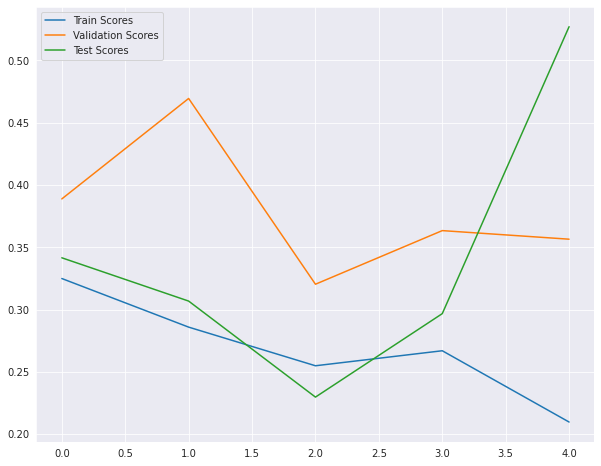

In [49]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_scores)),train_scores,label='Train Scores')
plt.plot(range(len(val_scores)),val_scores,label='Validation Scores')
plt.plot(range(len(test_scores)),test_scores,label='Test Scores')
plt.legend()

### Hold Out Score

Here, the same model is trained on all the data used on the Validation and tested on a Holdout Set never seen before.

In [61]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [62]:
X_train = preprocessing_X(X_train)
X_val = preprocessing_X(X_val)
X_holdout = preprocessing_X(X_holdout)

X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
X_holdout = X_holdout.drop(['ID','WF','Set','Month_Number'],axis=1)

y_train,scaler = preprocessing_y(y_train)
y_val,_ = preprocessing_y(y_val)
y_holdout,_ = preprocessing_y(y_holdout)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [63]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [64]:
model = LSTM_Model(input_shape)

In [65]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4649/4649 [==============================] - 37s 8ms/step - loss: 0.0617 - root_mean_squared_error: 0.2484 - val_loss: 0.1015 - val_root_mean_squared_error: 0.3186
Epoch 2/10
4483/4649 [===========================>..] - ETA: 1s - loss: 0.0335 - root_mean_squared_error: 0.1831

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

Here, Predicitions and True Labels of the Holdout Set are scaled back to measure the CAPE Error, and be compared on a Chart.

In [ ]:
preds = scaler.inverse_transform(preds)
y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

In [ ]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [ ]:
metric_cnr(preds,y_holdout)

In [ ]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Submission Generation

First, a function with all the preprocessing made to prepare data for network is defined.

Here's a Function with all the Process of Submit Gen for One Wind Farm. This Model is the Standard:

In [ ]:
def WF_submit_gen(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test = full_X_test.reset_index().drop('index',axis=1)
  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Months Loop
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue
    
    # Separate Month Data on Numpy Matrix
    ids = X_test.index
    X_test = full_X_test_split[[ids]]

    # Append Data Already Predicted
    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [ ]:
def WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Months Loop
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue

    # Append Data Already Predicted
    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Preprocessing Data
    X_train = preprocessing_X(X_train)
    X_val = preprocessing_X(X_val)
    X_test = preprocessing_X(X_test)

    X_train = X_train.drop(['ID','WF','Set'],axis=1)
    X_val = X_val.drop(['ID','WF','Set'],axis=1)
    X_test = X_test.drop(['ID','WF','Set'],axis=1)

    y_train,scaler_y = preprocessing_y(y_train)
    y_val,_ = preprocessing_y(y_val)

    # Subset Creation 

    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, _ = split_sequences(X_test.values,None,n_steps)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

Direct Submit Generation:

In [ ]:
def WF_submit_gen_3(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Split Train Data on Train and Validation Set
  X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, test_size=0.3, shuffle=False)

  # Model Creation and Training
  model = LSTM_Model(input_shape,batch_size=batch_size)
  callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

  # Prediction Generation
  pred = model.predict(full_X_test_split,batch_size = batch_size,callbacks=callbacks_list)
  pred = pred.reshape(pred.shape[0])

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(pred))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [ ]:
final_preds = pd.DataFrame()
for WF in full_data['WF'].unique():
  WF_preds = WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size)
  final_preds = final_preds.append(WF_preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706 - val_loss: 0.4896 - val_root_mean_squared_error: 0.6997
Epoch 2/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760 - val_loss: 0.4950 - val_root_mean_squared_error: 0.7036
Epoch 3/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862 - val_loss: 0.4967 - val_root_mean_squared_error: 0.7048
Epoch 4/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.2293 - root_mean_squared_error: 0.4788 - val_loss: 0.5008 - val_root_mean_squared_error: 0.7077


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.0669 - root_mean_squared_error: 0.2587 - val_loss: 0.2439 - val_root_mean_squared_error: 0.4939
Epoch 2/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0644 - root_mean_squared_error: 0.2537 - val_loss: 0.2399 - val_root_mean_squared_error: 0.4898
Epoch 3/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0649 - root_mean_squared_error: 0.2548 - val_loss: 0.2408 - val_root_mean_squared_error: 0.4907
Epoch 4/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0644 - root_mean_squared_error: 0.2539 - val_loss: 0.2389 - val_root_mean_squared_error: 0.4888
Epoch 5/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.0651 - root_mean_squared_error: 0.2552 - val_loss: 0.2422 - val_root_mean_squared_error: 0.4921


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0854 - root_mean_squared_error: 0.2923 - val_loss: 0.2284 - val_root_mean_squared_error: 0.4779
Epoch 2/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0849 - root_mean_squared_error: 0.2915 - val_loss: 0.2180 - val_root_mean_squared_error: 0.4669
Epoch 3/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926 - val_loss: 0.2149 - val_root_mean_squared_error: 0.4636
Epoch 4/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0830 - root_mean_squared_error: 0.2882 - val_loss: 0.2155 - val_root_mean_squared_error: 0.4642
Epoch 5/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807 - val_loss: 0.2259 - val_root_mean_squared_error: 0.4753
Epoch 6/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0772 - root_mean_squared_error: 0.2779 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0674 - root_mean_squared_error: 0.2597 - val_loss: 0.2646 - val_root_mean_squared_error: 0.5144
Epoch 2/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0675 - root_mean_squared_error: 0.2598 - val_loss: 0.2660 - val_root_mean_squared_error: 0.5157
Epoch 3/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.2626 - val_root_mean_squared_error: 0.5125
Epoch 4/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0663 - root_mean_squared_error: 0.2575 - val_loss: 0.2670 - val_root_mean_squared_error: 0.5167
Epoch 5/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0687 - root_mean_squared_error: 0.2622 - val_loss: 0.2676 - val_root_mean_squared_error: 0.5173
Epoch 6/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0678 - root_mean_squared_error: 0.2603 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4284/4284 [==============================] - 47s 11ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.2607 - val_root_mean_squared_error: 0.5106
Epoch 2/10
4284/4284 [==============================] - 46s 11ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143 - val_loss: 0.2543 - val_root_mean_squared_error: 0.5043
Epoch 3/10
4284/4284 [==============================] - 47s 11ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143 - val_loss: 0.2533 - val_root_mean_squared_error: 0.5033
Epoch 4/10
4284/4284 [==============================] - 47s 11ms/step - loss: 0.0468 - root_mean_squared_error: 0.2164 - val_loss: 0.2514 - val_root_mean_squared_error: 0.5014


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.1532 - root_mean_squared_error: 0.3914 - val_loss: 0.3641 - val_root_mean_squared_error: 0.6034
Epoch 2/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.1729 - root_mean_squared_error: 0.4158 - val_loss: 0.3458 - val_root_mean_squared_error: 0.5880
Epoch 3/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.1704 - root_mean_squared_error: 0.4128 - val_loss: 0.3439 - val_root_mean_squared_error: 0.5864
Epoch 4/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.1709 - root_mean_squared_error: 0.4134 - val_loss: 0.3421 - val_root_mean_squared_error: 0.5849


In [ ]:
final_preds = final_preds.reset_index().drop('index',axis=1)
final_preds['ID'] = pd.read_csv(r'random_submission_example.csv')['ID']
final_preds = final_preds.set_index('ID')

In [ ]:
final_preds

,Production
ID,
37376,3.023962
37377,3.018954
37378,3.013116
37379,3.011632
37380,3.011119
...,...
73900,1.387582
73901,1.387581
73902,1.387580


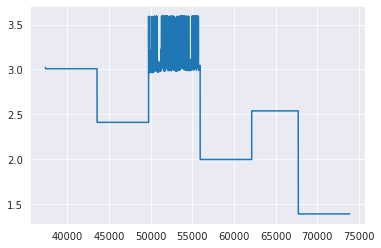

In [ ]:
plt.plot(final_preds.index,final_preds['Production'])

In [ ]:
final_preds.to_csv('Submission_LSTM.csv')

In [ ]:
from google.colab import files
files.download('Submission_LSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>